# IMDb

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/kritika.prakash/.fastai/data/imdb_sample/data_save.pkl'),
 PosixPath('/home/kritika.prakash/.fastai/data/imdb_sample/texts.csv')]

In [4]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [5]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

In [6]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [7]:
data_lm.save()

In [9]:
data = load_data(path)

In [10]:
#Tokenization
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the xxunk - up xxunk of xxmaj new xxmaj xxunk . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative


In [13]:
#Numericalization
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [15]:
data.train_ds[0][0]

Text [   2    5   64    5 ... 6124  916   17   53]

In [16]:
data.train_ds[0][0].data[:10]

array([   2,    5,   64,    5,  843,    5, 1686,  150,  104,   18])

# Using the data block API

In [17]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

In [18]:
bs=32

In [19]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/kritika.prakash/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/kritika.prakash/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/kritika.prakash/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/kritika.prakash/.fastai/data/imdb/README'),
 PosixPath('/home/kritika.prakash/.fastai/data/imdb/unsup'),
 PosixPath('/home/kritika.prakash/.fastai/data/imdb/test'),
 PosixPath('/home/kritika.prakash/.fastai/data/imdb/train')]

In [20]:
(path/'train').ls()

[PosixPath('/home/kritika.prakash/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/kritika.prakash/.fastai/data/imdb/train/neg'),
 PosixPath('/home/kritika.prakash/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/kritika.prakash/.fastai/data/imdb/train/pos')]

In [21]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [22]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [23]:
data_lm.show_batch()

idx,text
0,"the characters history and importance is gone more in depth . xxmaj like said before this show has the potential to be as good as smallville if not better . xxmaj how can the xxmaj execs at xxup cw not run a show that the audience has never seen yet . xxmaj justin xxmaj hartley plays a good xxup ac , he has a nice attractive co star xxmaj eva"
1,"' 80 's that are making a comeback , as those who were kids in that decade begin to edge their way ever so reluctantly into middle age . xxmaj that 's where the comedy , "" xxmaj kickin ' it xxmaj old xxmaj skool , "" comes in . \n \n xxmaj the premise of the movie is as follows : in 1986 , a ten - year"
2,"xxmaj groom for being an idiot . the 3rd person for being an arrogant dumb a$$hole . \n \n sorry for all the swearing . but this "" film "" su xxrep 4 x . xxmaj big time . xxbos xxmaj you could call xxmaj mr. xxmaj woodcock the latest version of xxmaj the xxmaj billy xxmaj bob xxmaj thornton xxmaj movie . xxmaj you know , that movie"
3,"' based on actual guideline ' , but there 's just that xxunk lot ) which does n't fit in ( too much xxunk to mention ) . \n \n xxmaj somehow , the xxmaj indian characters seem more white that they should ( as most are played by xxmaj indian ) and somehow white characters seem more like xxunk than actual officers and congressmen . xxmaj and of"
4,and orders xxmaj ethan xxmaj hunt to plant the xxmaj bad xxmaj guy 's xxmaj ex girlfriend in an attempt to undermine him . ( xxmaj would n't it have been better if they just attacked the xxup hq with commandos etc ) \n \n xxmaj in the original film xxmaj ethan xxmaj hunt gets promoted to xxmaj jim xxmaj phelps rank within the organisation but in the sequel


In [24]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [25]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


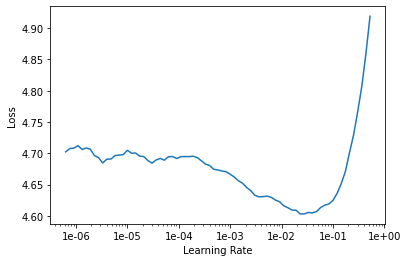

In [26]:
learn.recorder.plot(skip_end=15)

In [27]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.254209,4.108437,0.291154,24:53


In [28]:
learn.save('fit_head')

In [29]:
learn.load('fit_head');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))
learn.save('fine_tuned')

In [30]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [31]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because it was very well shot , but this was also one of the first films he had seen . This movie was very much like the first to see . It was a very good movie . 
 
 
I liked this movie because i think it would be funny then someone had a great movie . i did not like this film and my Troma bad taste was too bad . It had some good moments and this movie is very


In [32]:
learn.save_encoder('fit_head_enc')

# Classification

In [33]:
path = untar_data(URLs.IMDB)

In [34]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [36]:
data_clas = load_data(path, 'data_clas.pkl', bs=48)

In [37]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxunk ) is the developing world 's answer to xxmaj silence of the xxmaj lambs . xxmaj where ` xxmaj silence ' terrorized our peace of mind , ` xxmaj citizen ' exhausts and saddens us instead . xxmaj this dramatization of the xxmaj chikatilo case translates rather well , thanks to a xxmaj westernized friendship between two xxmaj rostov cops who become equals . \n \n citizenx",pos
xxbos xxmaj it has said that xxmaj the xxmaj movies and xxmaj baseball both thrived during xxmaj the xxmaj great xxmaj depression . xxmaj it appears that the grim realities of a xxmaj nation caught up in the aftermath of this xxmaj economic xxmaj disaster created a need for occasional relief for the populace . a temporary escape could be found in the on going soap opera that is xxmaj,pos
"xxbos i wo n't try to speculate as to what xxmaj brando was attempting . xxmaj at his best he turns in such oddball performances , insinuating so many things at once , that it does n't seem he does anything so much as play by unfailing instinct . xxmaj often it seems he is calling attention to some favored aspect of his character over all others , a concentration",pos
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first shoot-'em - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",pos


In [38]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fit_head_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos i have not yet decided whether this will replace xxmaj anaconda as " xxmaj the xxmaj worst xxmaj film i xxmaj have xxmaj ever xxmaj seen " . 
 
  xxmaj even if you ignore the dodgy accents , low production values and appalling camera work this film has absolutely nothing going for it . i only went to see it as i had read the book and wanted to see how they would work the complicated plot into a 2 hour film . 
 
  xxmaj the simple answer is - they did n't . xxmaj characters appear with little to no explanation as to who they are and then proceed to play no valuable part in the narrative . xxmaj even the main characters act without reason so that by the time the film reaches it 's climax you do n't care what happens to any of them . 
 
  i can accept that books occasionally need to be rewritten to fit into films and that it is perhaps unfair to judge this film against the book it was adapted from . xxmaj

In [39]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


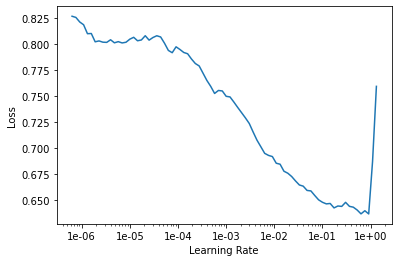

In [40]:
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.423072,0.352326,0.845200,03:03


In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
learn.predict("I really loved that movie, it was awesome!")

# Tabular

In [43]:
from fastai import *
from fastai.tabular import *

In [45]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

In [46]:
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [FillMissing, Categorify, Normalize]

In [47]:
test = TabularList.from_df(df.iloc[800:1000].copy(), path=path, cat_names=cat_names, cont_names=cont_names)

In [48]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(800,1000)))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [49]:
data.show_batch(rows=10)

workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,target
?,10th,Never-married,?,Own-child,White,False,-1.5823,-0.4324,-1.5958,<50k
Private,Some-college,Divorced,Prof-specialty,Not-in-family,White,False,0.6166,1.3219,-0.0312,>=50k
Private,Some-college,Divorced,Adm-clerical,Unmarried,White,False,-0.3362,-0.1760,-0.0312,<50k
Private,11th,Married-civ-spouse,Transport-moving,Husband,White,False,0.6899,2.1203,-1.2046,<50k
Private,HS-grad,Never-married,Other-service,Not-in-family,White,False,-0.8493,-0.2993,-0.4224,<50k
Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,False,-0.5561,-0.1776,1.1422,>=50k
Private,Bachelors,Married-civ-spouse,Exec-managerial,Wife,White,False,-0.3362,-0.0078,1.1422,<50k
Self-emp-inc,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,False,1.3496,-0.6136,1.9245,>=50k
Federal-gov,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,False,0.2502,-0.5460,1.1422,>=50k
Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,False,0.3968,0.3102,-0.4224,<50k


In [50]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

In [51]:
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.368500,0.391308,0.815000,00:04


In [52]:
row = df.iloc[0]

In [53]:
learn.predict(row)

(Category tensor(1), tensor(1), tensor([0.3320, 0.6680]))

# Collaborative Filtering

In [1]:
from fastai.collab import *
from fastai.tabular import *

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/home/kritika.prakash/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [5]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [6]:
y_range = [0,5.5]

In [7]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [8]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.624769,0.949369,00:00
1,0.862080,0.677547,00:00
2,0.651533,0.670411,00:00
